## 6. GLMの応用範囲をひろげる
- [Pythonで実装しながら緑本を学ぶ (第6章 GLMの応用範囲を広げる -ロジスティック回帰など-)](https://ohke.hateblo.jp/entry/2018/02/12/230000)

In [2]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import os
import requests

/home/yoshino/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
file_path = './data/data4a.csv'

if not os.path.isfile(file_path):
  response = requests.get('https://kuboweb.github.io/-kubo/stat/iwanamibook/fig/binomial/data4a.csv')
  with open (file_path, 'wb') as f:
      f.write(response.content)
      f.close()

df = pd.read_csv(file_path)
df.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [10]:
df.describe()

,N,y,x
count,100.0,100.000000,100.000000
mean,8.0,5.080000,9.967200
std,0.0,2.743882,1.088954
min,8.0,0.000000,7.660000
25%,8.0,3.000000,9.337500
50%,8.0,6.000000,9.965000
75%,8.0,8.000000,10.770000
max,8.0,8.000000,12.440000


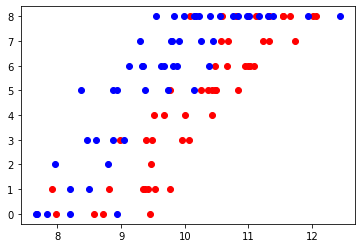

In [11]:
# 前章まではデータの分布をみてポアソン分布に似ているかも？と仮定して議論を薦めていたが、ここでは、
# 問題の性質上、仮定すべきは二項分布として決まってくる
control = df[df['f'] == 'C']
control_x = control[['x']].to_numpy().tolist()
control_y = control[['y']].to_numpy().tolist()

treatment = df[df['f'] == 'T']
treatment_x = treatment[['x']].to_numpy().tolist()
treatment_y = treatment[['y']].to_numpy().tolist()

plt.scatter(control_x, control_y, color='red')
plt.scatter(treatment_x, treatment_y, color='blue')

### 6.4 ロジスティック回帰とロジットリンク関数
- GLM(一般線形化モデル)において以下を指定するということ
  - 確率分布: 二項分布
  - リンク関数： ロジットリンク関数(ロジスティック関数を変形したもの)

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [15]:
# polarsだと上手く行かなかった
# これまでのポアソン分布のモデルは↓みたいな感じだった
# f_model = smf.glm(formula='y ~ f2', data=df, family=sm.families.Poisson())
xf_model_result = smf.glm(formula='y + I(N - y) ~ x + f', data=df, family=sm.families.Binomial()).fit()

# リンク関数にはロジット関数を使い、線形予測子は以下となる。
# z = β1 + β2 x X + β3 x f 
# {β1, β2, β3} = {-19.5361, 2.0215, 1.9524}
xf_model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Sat, 04 Feb 2023   Deviance:                       123.03
Time:                        12:50:34   Pearson chi2:                     109.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9768
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.000     -22.307     -16.765
f[T.T]         2.0215      0.231      8.740      0.000       1.568       2.475
x              1.9524      0.139     14.059      0.000       1.680       2.225
==============================================================================
"""

In [16]:
print(xf_model_result.params)
b1 = xf_model_result.params[0]
b2 = xf_model_result.params[2]
b3 = xf_model_result.params[1]

x = 0.1
f = 1
z1 = np.exp(b1 + b2 * x + b3 * f) 
z2 = np.exp(b1 + b2 * (x + 1) + b3 * f) 
print('オッズ比: ', z2 / z1)

Intercept   -19.536066
f[T.T]        2.021506
x             1.952406
dtype: float64
オッズ比:  7.04562150915963


In [17]:
# AICの比較
x_model_result = smf.glm(formula='y + I(N - y) ~ x', data=df, family=sm.families.Binomial()).fit()
f_model_result = smf.glm(formula='y + I(N - y) ~ f', data=df, family=sm.families.Binomial()).fit()

In [18]:
# x + fが一番小さいAIC: 最良のモデル
print('x : ', x_model_result.aic)
print('f : ', f_model_result.aic)
print('x + f : ', xf_model_result.aic)

x :  364.3454432837159
f :  637.7597534566678
x + f :  272.21112928522325


### 6.5 交互作用の入った線形予測子
- featureエンジニアリングみたい

In [40]:
xf_cross_model_result = smf.glm(formula='y + I(N - y) ~ x * f', data=df, family=sm.families.Binomial()).fit()
print('AIC: ', xf_cross_model_result.aic) # x + fのモデルより悪化している
print(xf_cross_model_result.params)
xf_cross_model_result.summary()

AIC:  273.61059672597395
Intercept   -18.523322
f[T.T]       -0.063764
x             1.852509
x:f[T.T]      0.216338
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       96
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -132.81
Date:                Fri, 20 Jan 2023   Deviance:                       122.43
Time:                        08:28:34   Pearson chi2:                     109.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9769
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -18.5233      1.886     -9.821      0.000     -22.220     -14.827
f[T.T]        -0.0638      2.704     -0.024      0.981      -5.363       5.235
x              1.8525      0.186      9.983      0.000       1.489       2.216
x:f[T.T]       0.2163      0.280      0.772      0.440      -0.333       0.765
==============================================================================
"""

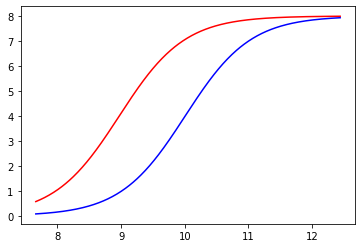

In [81]:
b1 = xf_model_result.params[0]
b2 = xf_model_result.params[2]
b3 = xf_model_result.params[1]

xs = np.arange(df['x'].min(), df['x'].max() + 0.01, 0.01)

logistic_xf_control = lambda x : 1 / (1 + np.exp(-(b1 + b2 * x)))
logistic_xf_treatment = lambda x : 1 / (1 + np.exp(-(b1 + b2 * x + b3)))

y_xf_control = []
for x in xs:
  y_xf_control.append(logistic_xf_control(x) * 8) # 確率が1の時: 種子数が8の時
y_xf_treatment = []
for x in xs:
  y_xf_treatment.append(logistic_xf_treatment(x) * 8)

plt.plot(xs, y_xf_control, c='blue')
plt.plot(xs, y_xf_treatment, c='red')

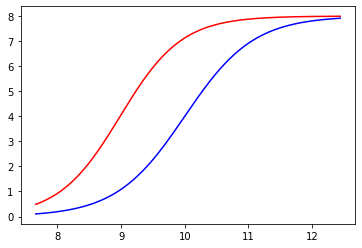

In [82]:
b1_cross = xf_cross_model_result.params[0]
b2_cross = xf_cross_model_result.params[2]
b3_cross = xf_cross_model_result.params[1]
b4_cross = xf_cross_model_result.params[3]


logistic_xf_cross_control = lambda x : 1 / (1 + np.exp(-(b1_cross + b2_cross * x)))
logistic_xf_cross_treatment = lambda x : 1 / (1 + np.exp(-(b1_cross + (b2_cross + b4_cross) * x + b3_cross)))

y_xf_cross_control = []
for x in xs:
  y_xf_cross_control.append(logistic_xf_cross_control(x) * 8) # 確率が1の時: 種子数が8の時
y_xf_cross_treatment = []
for x in xs:
  y_xf_cross_treatment.append(logistic_xf_cross_treatment(x) * 8)

plt.plot(xs, y_xf_cross_control, c='blue')
plt.plot(xs, y_xf_cross_treatment, c='red')

### 6.6 割算値の統計モデリングはやめよう

In [3]:
file_path = './data/data4b.csv'

if not os.path.isfile(file_path):
  response = requests.get('https://kuboweb.github.io/-kubo/stat/iwanamibook/fig/binomial/data4b.csv')
  with open (file_path, 'wb') as f:
      f.write(response.content)
      f.close()


dfb = pd.read_csv(file_path)
dfb.head()

,y,x,A
0,57,0.68,10.3
1,64,0.27,15.6
2,49,0.46,10.0
3,64,0.45,14.9
4,82,0.74,14.0


In [84]:
dfb.describe()

,y,x,A
count,100.000000,100.000000,100.000000
mean,48.090000,0.514100,10.468000
std,17.137056,0.188573,2.927262
min,13.000000,0.050000,3.500000
25%,36.000000,0.400000,8.800000
50%,46.000000,0.515000,10.300000
75%,59.500000,0.642500,12.150000
max,95.000000,0.990000,17.400000


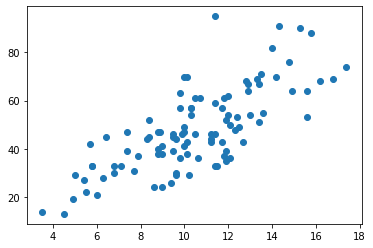

In [88]:
plt.scatter(dfb['A'].values, dfb['y'].values)

In [92]:
model_offset_result = smf.glm(formula='y ~ x', offset=np.log(dfb['A']), data=dfb, family=sm.families.Poisson()).fit()
model_offset_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -323.17
Date:                Fri, 20 Jan 2023   Deviance:                       81.608
Time:                        09:41:54   Pearson chi2:                     81.5
No. Iterations:                     4   Pseudo R-squ. (CS):             0.8345
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9731      0.045     21.600      0.000       0.885       1.061
x              1.0383      0.078     13.364      0.000       0.886       1.191
==============================================================================
"""

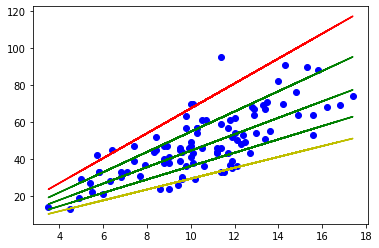

In [115]:
def expected_y(x):
  expected_y = []
  for i, row in dfb.iterrows():
    y = np.exp(model_offset_result.params[0] + model_offset_result.params[1] * x  + np.log(row['A']))
    expected_y.append(y)
  return expected_y

y1 = expected_y(0.1)
y2 = expected_y(0.3)
y3 = expected_y(0.5)
y4 = expected_y(0.7)
y5 = expected_y(0.9)

# xを固定して予測したモデルにAをいれていく
plt.plot(dfb['A'].values, y1, c='y')
plt.plot(dfb['A'].values, y2, c='g')
plt.plot(dfb['A'].values, y3, c='g')
plt.plot(dfb['A'].values, y4, c='g')
plt.plot(dfb['A'].values, y5, c='r')
plt.scatter(dfb['A'].values, dfb['y'].values, c='b')

### 6.7 正規分布とその尤度

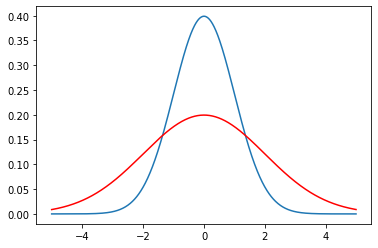

In [119]:
from scipy.stats import norm

x = np.arange(-5.0, 5.0, 0.01)
plt.plot(x, [norm.pdf(x_i, 0, 1) for x_i in x], label='平均=0, 分散=1')
plt.plot(x, [norm.pdf(x_i, 0, 2) for x_i in x], label='平均=0, 分散=2', c='r')

In [120]:
# 確率の計算(x: 1.8 ~ 1.2の間の確率)
norm.cdf(1.8, 0, 1) - norm.cdf(1.2, 0, 1)

0.07913935110878245

### 6.8 ガンマ分布のGLM

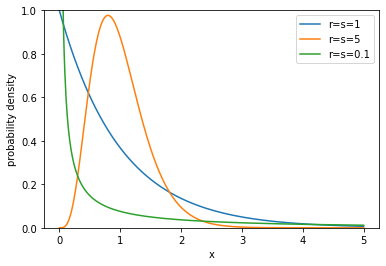

In [121]:
# ガンマ分布の確率密度関数
from scipy.stats import gamma

x = np.arange(0.00, 5.01, 0.01)

plt.plot(x, [gamma.pdf(x_i, a=1, scale=1/1) for x_i in x], label='r=s=1')
plt.plot(x, [gamma.pdf(x_i, a=5, scale=1/5) for x_i in x], label='r=s=5')
plt.plot(x, [gamma.pdf(x_i, a=0.1, scale=1/0.1) for x_i in x], label='r=s=0.1')
plt.ylim([0.0, 1.0])
plt.legend()
plt.xlabel('x')
plt.ylabel('probability density')
plt.show()